In [7]:
!git clone https://github.com/daffirds/RobloxGameChatAnalysis.git

Cloning into 'RobloxGameChatAnalysis'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 17 (delta 3), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (17/17), 371.36 KiB | 10.04 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from transformers import RobertaTokenizer, TFRobertaModel
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Bidirectional, GRU, AdditiveAttention, Lambda, LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import re

In [9]:
# Load the dataset
file_path = '/content/RobloxGameChatAnalysis/indonesian_chat.csv'
df = pd.read_csv(file_path)
df['label'] = df['label'].astype(str)

In [22]:
def clean_chat_text(text):
    text = text.replace('\\n', ' ').replace('\n', ' ')
    sentences = re.sub(r'(\\x[0-9a-f]{2})|([^a-zA-Z0-9\s])', ' ', text)
    return re.sub(r'\s+', ' ', sentences).strip()

df['chat'] = df['chat'].apply(clean_chat_text)

In [24]:
# Encode labels
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])

X_text = df['chat'].values
y = df['label'].values
num_classes = len(np.unique(y))

In [25]:
# Load BERT tokenizer and model
MODEL_NAME = 'flax-community/indonesian-roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)
roberta_model = TFRobertaModel.from_pretrained(MODEL_NAME)

max_len = 128

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'roberta.embeddings.position_ids', 'lm_head.dense.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [26]:
# Tokenize dengan RoBERTa tokenizer
def encode_texts(texts):
    return tokenizer(
        list(texts),
        padding='max_length',
        truncation=True,
        max_length=max_len,
        return_tensors='np'
    )

encodings = encode_texts(X_text)
X_input_ids = encodings['input_ids']
X_attention_mask = encodings['attention_mask']

In [27]:
# Split the data
train_idx, val_idx = train_test_split(
    np.arange(len(X_text)), test_size=0.2, stratify=y, random_state=42
)

X_train_ids = X_input_ids[train_idx]
X_val_ids = X_input_ids[val_idx]
X_train_mask = X_attention_mask[train_idx]
X_val_mask = X_attention_mask[val_idx]
y_train = y[train_idx]
y_val = y[val_idx]

In [28]:
# Build RoBERTa + Stacked BiGRU + Attention model
def build_model():
    input_ids = Input(shape=(max_len,), dtype=tf.int32, name='input_ids')
    attention_mask = Input(shape=(max_len,), dtype=tf.int32, name='attention_mask')

    # --- PERUBAHAN 3: Gunakan model RoBERTa ---
    # Gunakan Lambda untuk memastikan kompatibilitas
    roberta_output = Lambda(lambda x: roberta_model(x[0], attention_mask=x[1])[0], output_shape=(max_len, 768))([input_ids, attention_mask])

    x = Bidirectional(GRU(64, return_sequences=True))(roberta_output)
    x = LayerNormalization()(x)
    x = Dropout(0.3)(x)

    x = Bidirectional(GRU(32, return_sequences=True))(x)
    x = LayerNormalization()(x)
    x = Dropout(0.3)(x)

    attention_out = AdditiveAttention()([x, x])
    x = Dropout(0.3)(attention_out)

    x = Bidirectional(GRU(32))(x)
    x = Dropout(0.3)(x)

    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=[input_ids, attention_mask], outputs=output)
    model.compile(optimizer=Adam(learning_rate=2e-5, clipnorm=1.0), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Initialize the model
model = build_model()

In [29]:
# Train the model
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, min_lr=1e-6)
]

history = model.fit(
    [X_train_ids, X_train_mask],
    y_train,
    validation_data=([X_val_ids, X_val_mask], y_val),
    epochs=10,
    batch_size=16,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/10
536/536 ━━━━━━━━━━━━━━━━━━━━ 137s 223ms/step - accuracy: 0.2843 - loss: 1.5208 - val_accuracy: 0.4797 - val_loss: 1.1913 - learning_rate: 2.0000e-05
Epoch 2/10
536/536 ━━━━━━━━━━━━━━━━━━━━ 135s 210ms/step - accuracy: 0.4199 - loss: 1.2926 - val_accuracy: 0.5493 - val_loss: 1.0698 - learning_rate: 2.0000e-05
Epoch 3/10
536/536 ━━━━━━━━━━━━━━━━━━━━ 142s 210ms/step - accuracy: 0.4999 - loss: 1.1489 - val_accuracy: 0.5759 - val_loss: 1.0092 - learning_rate: 2.0000e-05
Epoch 4/10
536/536 ━━━━━━━━━━━━━━━━━━━━ 167s 257ms/step - accuracy: 0.5498 - loss: 1.0682 - val_accuracy: 0.5997 - val_loss: 0.9711 - learning_rate: 2.0000e-05
Epoch 5/10
536/536 ━━━━━━━━━━━━━━━━━━━━ 116s 208ms/step - accuracy: 0.5882 - loss: 1.0079 - val_accuracy: 0.6165 - val_loss: 0.9450 - learning_rate: 2.0000e-05
Epoch 6/10
536/536 ━━━━━━━━━━━━━━━━━━━━ 142s 208ms/step - accuracy: 0.6066 - loss: 0.9683 - val_accuracy: 0.6348 - val_loss: 0.9224 - learning_rate: 2.0000e-05
Epoch 7/10
536/536 ━━━━━━━━━━━━━━━━━━━━ 

In [30]:
# Evaluate
y_pred = np.argmax(model.predict([X_val_ids, X_val_mask]), axis=-1)

accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')
f1 = f1_score(y_val, y_pred, average='weighted')

print("\nEvaluation Results:")
print(f"  Accuracy: {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall: {recall:.4f}")
print(f"  F1-Score: {f1:.4f}")

67/67 ━━━━━━━━━━━━━━━━━━━━ 24s 324ms/step

Evaluation Results:
  Accuracy: 0.6637
  Precision: 0.6685
  Recall: 0.6637
  F1-Score: 0.6649


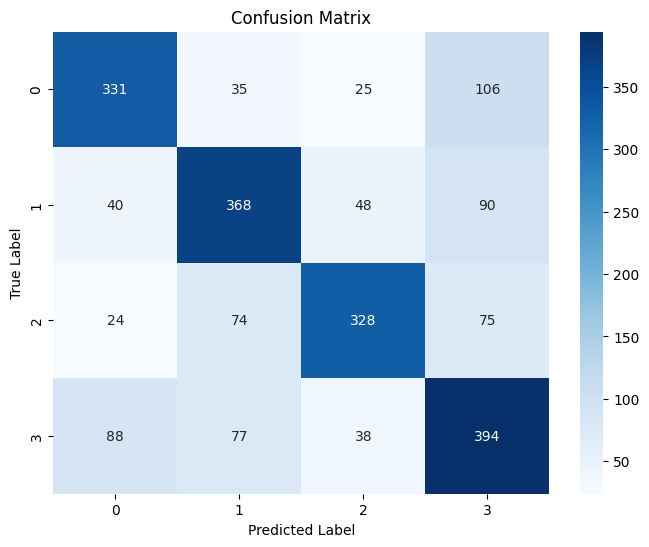

In [31]:
# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [20]:
model.save('RoBERTa_StackedBiGRU_Attention_Model.h5')